In [20]:
import os
import sys
import json
import time
import pickle
import gspread
import numpy as np
import pandas as pd
import pingouin as pg
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy import integrate, signal, stats, fftpack

## The following is needed to export text correctly for Illustrator ##
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)

In [4]:
%matplotlib notebook

Load Zap_Zip-log_exp to get metadata for experiments

In [5]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

Define areas of interest to plot population activity

In [6]:
areas_of_interest = {
    'MO': [
        'MOp1', 'MOp2/3', 'MOp5', 'MOp6a', 'MOp6b',
        'MOs1', 'MOs2/3', 'MOs5', 'MOs6a', 'MOs6b'
    ],
    'ACA': [
        'ACAd1', 'ACAd2/3', 'ACAd5', 'ACAd6a', 'ACAd6b',
        'ACAv1', 'ACAv2/3', 'ACAv5', 'ACAv6a', 'ACAv6b'
    ],
    'SS': [
        'SSp-bfd1', 'SSp-bfd2/3', 'SSp-bfd4', 'SSp-bfd5', 'SSp-bfd6a', 'SSp-bfd6b',
        'SSp-ll1', 'SSp-ll2/3', 'SSp-ll4', 'SSp-ll5', 'SSp-ll6a', 'SSp-ll6b',
        'SSp-tr1', 'SSp-tr2/3', 'SSp-tr4', 'SSp-tr5', 'SSp-tr6a', 'SSp-tr6b'
    ],
    'VIS': [
        'VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b',
        'VISam1', 'VISam2/3', 'VISam4', 'VISam5', 'VISam6a', 'VISam6b',
        'VISpm1', 'VISpm2/3', 'VISpm4', 'VISpm5', 'VISpm6a', 'VISpm6b',
        'VISrl1', 'VISrl2/3', 'VISrl4', 'VISrl5', 'VISrl6a', 'VISrl6b',
    ],
    'MO-TH': [
        'AV', 'CL', 'MD', 'PO', 'RT', 'VAL', 'VPL', 'VPM', 'VM'
    ],
}

In [7]:
area_colors = {
    'MO': (31/255, 157/255, 90/255), # [31, 157, 90] 'blue'
    'ACA': (64/255, 166/255, 102/255), # [64, 166, 102] 'deepskyblue'
    'SS': (24/255, 128/255, 100/255), # [24, 128, 100] 'blueviolet'
    'VIS': (8/255, 133/255, 140/255), # [8, 133, 140] 'green'
    'MO-TH': (255/255, 112/255, 128/255), # [255, 112, 128] 'steelblue'
#     'VIS-TH': 'olivedrab'
}

In [8]:
# state_colors = {
#     'awake': (120/255, 156/255, 74/255),
#     'anesthetized': (130/255, 122/255, 163/255),
#     'recovery': (93/255, 167/255, 229/255)
# }
state_colors = {
    'resting': 'royalblue',
    'running': 'seagreen',
    'anesthetized': 'indianred',
}

In [9]:
## define colors for CB readers
CBorange = (230/255, 159/255, 0/255)
CBbgreen = (0/255, 158/255, 115/255)

#### Functions

In [10]:
def get_stim_event_inds(stim_table, stim_type, stim_param, sweep, trials='resting'):
    if trials == 'resting':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == True)
        ].index.values
    elif trials == 'running':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == False)
        ].index.values
    else:
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True)
        ].index.values

In [11]:
def get_metadata(mdata_dict, metadf):
    exp_meta = metadf[(
        (metadf['mouse_name'].str.contains(mdata_dict['exp'].mouse)) &
        (metadf['exp_name'].str.contains(os.path.basename(os.path.dirname(mdata_dict['exp'].experiment_folder))))
    )].squeeze()
    
    ## Gets EEG_bad_chs, stim_currents, and PCI_stim ##
    try:
        EEG_bad_chs = mdata_dict['bad_chs']
    except KeyError:
        badchstr = exp_meta['EEG bad_channels'].replace(' ','')
        EEG_bad_chs = []
        for char in badchstr.split(','):
            if char.isdecimal():
                EEG_bad_chs.append(int(char))
    currentstr = exp_meta['Current (uA)'].replace(' ','')
    stim_currents = []
    for char in currentstr.split('/'):
        if char.isdecimal():
            stim_currents.append(char)
    if len(stim_currents) > 1:
        PCI_stim = stim_currents[1]
    elif len(currents_list) == 1:
        PCI_stim = stim_currents[0]
    else:
        print('No stim current listed in Zap_Zip-log_exp')
    return EEG_bad_chs, stim_currents, PCI_stim

In [12]:
def shuffledAUC(data_traces, data_time, AUCwindow=[0.0, 0.5], nshuff=1000):
    BLinds = np.nonzero((data_time > AUCwindow[0]) & (data_time < AUCwindow[1]))[0]
    Rinds = np.nonzero((data_time > -AUCwindow[1]) & (data_time < -AUCwindow[0]))[0]
    indsize = len(BLinds) + len(Rinds)

    shuffaucs = np.zeros((nshuff), dtype=float)
    for shuffi in range(nshuff):
        trialstarts = np.random.uniform(low=0, high=data_traces.shape[0] - indsize, size=data_traces.shape[2]).astype(int)
        shufftrials = np.zeros((indsize, data_traces.shape[1], data_traces.shape[2]), dtype=float)
        for triali, startind in enumerate(trialstarts):
            shufftrials[:,:,triali] = data_traces[startind:startind+indsize,:,triali]
        avgavg = np.mean(np.mean(shufftrials, axis=2), axis=1)
        shuffz = (avgavg - np.mean(avgavg[:len(BLinds)])) / np.std(avgavg[:len(BLinds)])
        shuffaucs[shuffi] = integrate.simps(np.abs(shuffz[len(BLinds):]), data_time[Rinds], axis=0, even='last')
    return shuffaucs

In [13]:
def p_stars(test_pval):
    if test_pval < 0.001:
        return '***'
    elif test_pval < 0.01:
        return '**'
    elif test_pval < 0.05:
        return '*'
    else:
        return 'n.s.'

## Load subjects from file

In [14]:
with open(r'C:\Users\lesliec\OneDrive - Allen Institute\data\all_CSD_subjects.json') as subjects_file:
    multi_sub_dict = json.load(subjects_file)

In [15]:
for group, group_subs in multi_sub_dict.items():
    print(group)
    print('')
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        mdata['exp'] = EEGexp(mdata['data_loc'], preprocess=False, make_stim_csv=False)
    print('')

MOs_superficial

 575102
Experiment type: electrical and sensory stimulation
 571619
Experiment type: electrical stimulation

MOs_deep

 546655
Experiment type: electrical and sensory stimulation
 551399
Experiment type: electrical stimulation
 551397
Experiment type: electrical and sensory stimulation
 569062
Experiment type: electrical and sensory stimulation
 569068
Experiment type: electrical and sensory stimulation
 569069
Experiment type: electrical and sensory stimulation
 569064
Experiment type: electrical and sensory stimulation
 569073
Experiment type: electrical and sensory stimulation
 571619
Experiment type: electrical stimulation

SSp_superficial

 571620
Experiment type: electrical and sensory stimulation
 586466
Experiment type: electrical and sensory stimulation
 586468
Experiment type: electrical and sensory stimulation
 590479
Experiment type: electrical stimulation
 590480
Experiment type: electrical and sensory stimulation
 599017
Experiment type: electrical and se

In [16]:
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\manuscript_figs'

## All subjects

In [17]:
## Parameters ##
sigalpha = 0.05

ctx_regions = ['MO', 'ACA', 'SS', 'VIS']
celltype = 'RS'
time_bin = 0.01 # size of time bins (s)

test_currents = ['medium']
test_states = ['awake']

auc_window = [0.0, 0.5]
nshuff = 1000 # how many shuffles to do

example_mouse = {
    'MOs_deep': '571619',
}

In [18]:
## Compares response AUC to onset-shuffled AUC ##
example_traces = {}
all_subs_auc_stats = []
for group, group_subs in multi_sub_dict.items():
    print(group)
    print('')
    stim_area = group[:2]
    stim_depth = group.split('_')[-1]
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        evoked_data_folder = os.path.join(mdata['exp'].data_folder, 'evoked_data')
        
        ## Load unit info ##
        fn_units_info = os.path.join(evoked_data_folder, 'all_units_info.csv')
        if os.path.exists(fn_units_info):
            unit_info = pd.read_csv(fn_units_info)
            with open(os.path.join(evoked_data_folder, 'units_event_spikes.pkl'), 'rb') as unit_file:
                all_unit_event_spikes = pickle.load(unit_file)
        else:
            print('  {} not found. Not analyzing this subject.'.format(fn_units_stats))
            continue

        ## Grab exp metadata from Zap_Zip-log_exp ##
        bad_chs, currents_list, PCI_stim_amp = get_metadata(mdata, zzmetadata)

        ## Load stim log (includes running speed now) ##
        stim_log = pd.read_csv(mdata['exp'].stimulus_log_file)
        stim_log = stim_log.astype({'parameter': str})
        event_window = all_unit_event_spikes['event_window']
        bins = np.arange(event_window[0], event_window[1] + time_bin, time_bin)
        timex = bins[:-1] + time_bin/2
        
        ## Load LFP info and traces ##
        with open(os.path.join(evoked_data_folder, 'evokedLFPinfo.json')) as info_file:
            LFPinfo = json.load(info_file)
        LFP_event_ts = np.load(os.path.join(evoked_data_folder, 'evokedLFPtimestamps.npy'))
        
        ## Load region LFP traces ONLY for regions with units AND LFP ##
        reg_allLFPtraces = {}
        reg_allCSDtraces = {}
        reg_unit_info = {}
        for region in ctx_regions:
            regdf = unit_info[(unit_info['cell_type'] == celltype) & (unit_info['parent'] == region)]
            if (len(regdf) > 8) and (region in LFPinfo.keys()) and (region in mdata['CSD_regions']):
                reg_unit_info[region] = regdf.sort_values(by='depth').reset_index(drop=True)
                reg_allLFPtraces[region] = np.load(os.path.join(evoked_data_folder, region + '_evokedLFPtraces.npy'))
                reg_allCSDtraces[region] = np.load(os.path.join(evoked_data_folder, region + '_evokedCSDtraces.npy'))
            else:
                print('  Excluding {}'.format(region))
        if len(reg_allLFPtraces) == 0:
            print('  Subject has no regions to analyze.\n')
            continue
        
        ## Get event inds ##
        all_event_inds = {}
        for leveli, parami in zip(['low', 'medium', 'high'], currents_list):
            all_event_inds[leveli] = {}
            for statei in ['awake', 'anesthetized']:
                sweeps = mdata['states'][statei]
                if not sweeps:
                    continue
                state_events = []
                for sweepi in sweeps:
                    events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials='all')
                    if len(events) == 0:
                        continue
                    state_events.append(events)
                all_event_inds[leveli][statei] = np.concatenate(state_events)
                if statei == 'awake':
                    substates = ['resting', 'running']
                    for substatei in substates:
                        state_events = []
                        for sweepi in sweeps:
                            events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials=substatei)
                            if len(events) == 0:
                                continue
                            state_events.append(events)
                        all_event_inds[leveli][substatei] = np.concatenate(state_events)
        
        LFP_traces = {}
        CSD_traces = {}
        unit_traces = {}
        print('  Getting LFP and unit stats...')
        for leveli in test_currents:
            LFP_traces[leveli] = {}
            CSD_traces[leveli] = {}
            unit_traces[leveli] = {}
            for statei in test_states:
                event_inds = all_event_inds[leveli][statei]
                LFP_traces[leveli][statei] = {}
                CSD_traces[leveli][statei] = {}
                unit_traces[leveli][statei] = {}

                for region in reg_allLFPtraces.keys():
                    stim_ctx = region == stim_area
                    
                    ## Get evoked LFP traces ##
                    ch_mask = np.array(LFPinfo[region]['ch_mask'])
                    ch_areas = np.array(LFPinfo[region]['ch_areas'])
                    layer_mask = np.array([False if '1' in x else True for x in ch_areas])
                    LFPtraces = reg_allLFPtraces[region][:, :, event_inds][:, layer_mask*ch_mask, :]
                    LFP_traces[leveli][statei][region] = [LFP_event_ts, np.mean(LFPtraces, axis=2)]
                    ## Get AUC ##
                    pop_LFP = np.mean(np.abs(np.mean(LFPtraces, axis=2)), axis=1)
                    pop_LFP_zscore = (pop_LFP - np.mean(pop_LFP[LFP_event_ts < 0])) / np.std(pop_LFP[LFP_event_ts < 0])
                    lfpinds = np.nonzero((LFP_event_ts > auc_window[0]) & (LFP_event_ts < auc_window[1]))[0]
                    lfpauc = integrate.simps(np.abs(pop_LFP_zscore)[lfpinds], LFP_event_ts[lfpinds], axis=0, even='last')
                    ## Get p-value ##
                    lfp_shuffauc = shuffledAUC(LFPtraces, LFP_event_ts, AUCwindow=auc_window, nshuff=nshuff)
                    LFPpval = np.sum(lfp_shuffauc > lfpauc) / nshuff
                    Zlfpauc_shuffauc = (lfpauc - np.mean(lfp_shuffauc)) / np.std(lfp_shuffauc)
                    
                    ## Get evoked CSD traces ##
                    CSDtraces = -0.3 * reg_allCSDtraces[region][:, :, event_inds] * 10 # the units are uA/mm^3 now
                    CSD_traces[leveli][statei][region] = [LFP_event_ts, np.mean(CSDtraces, axis=2)]
                    ## Get AUC ##
                    pop_CSD = np.mean(np.abs(np.mean(CSDtraces, axis=2)), axis=1)
                    pop_CSD_zscore = (pop_CSD - np.mean(pop_CSD[LFP_event_ts < 0])) / np.std(pop_CSD[LFP_event_ts < 0])
                    csdauc = integrate.simps(np.abs(pop_CSD_zscore)[lfpinds], LFP_event_ts[lfpinds], axis=0, even='last')
                    ## Get p-value ##
                    csd_shuffauc = shuffledAUC(CSDtraces, LFP_event_ts, AUCwindow=auc_window, nshuff=nshuff)
                    CSDpval = np.sum(csd_shuffauc > csdauc) / nshuff
                    Zcsdauc_shuffauc = (csdauc - np.mean(csd_shuffauc)) / np.std(csd_shuffauc)
                    
                    ## Get unit firing rates ##
                    all_firing_rates = np.empty((len(timex), len(reg_unit_info[region]), len(event_inds))) * np.nan
                    for uni, uniti in enumerate(reg_unit_info[region]['unit_id'].values):
                        for ii, evi in enumerate(event_inds):
                            spikecounts, edges = np.histogram(all_unit_event_spikes['event_spikes'][uniti][evi], bins)
                            all_firing_rates[:, uni, ii] = spikecounts / time_bin
                    unit_traces[leveli][statei][region] = [timex, np.mean(all_firing_rates, axis=2)]
                    ## Get AUC ##
                    pop_avg = np.mean(np.mean(all_firing_rates, axis=2), axis=1)
                    pop_zscore = (pop_avg - np.mean(pop_avg[timex < 0])) / np.std(pop_avg[timex < 0])
                    uinds = np.nonzero((timex > auc_window[0]) & (timex < auc_window[1]))[0]
                    unitauc = integrate.simps(np.abs(pop_zscore)[uinds], timex[uinds], axis=0, even='last')
                    ## Get p-value ##
                    unit_shuffauc = shuffledAUC(all_firing_rates, timex, AUCwindow=auc_window, nshuff=nshuff)
                    unitpval = np.sum(unit_shuffauc > unitauc) / nshuff
                    Zunitauc_shuffauc = (unitauc - np.mean(unit_shuffauc)) / np.std(unit_shuffauc)
                    
                    ## Store stats ##
                    all_subs_auc_stats.append([
                        group, mouse_num, stim_area, stim_depth, region, stim_ctx, LFPtraces.shape[1],
                        all_firing_rates.shape[1], leveli, statei, LFPpval, lfpauc, Zlfpauc_shuffauc,
                        CSDpval, csdauc, Zcsdauc_shuffauc, unitpval, unitauc, Zunitauc_shuffauc
                    ])
        
        if (group in example_mouse.keys()) and (mouse_num == example_mouse[group]):
            example_traces['LFP'] = LFP_traces
            example_traces['CSD'] = CSD_traces
            example_traces['POPFR'] = unit_traces
        del unit_info, all_unit_event_spikes, stim_log, LFPinfo, reg_allLFPtraces, reg_allCSDtraces, reg_unit_info
        del LFP_traces, CSD_traces, unit_traces
    print('')
## Create stats dataframe ##
all_subs_auc_df = pd.DataFrame(all_subs_auc_stats, columns=[
    'group', 'mouse', 'stim_area', 'stim_depth', 'region', 'stim_cortex', 'num_chs', 'num_units', 'stim_level', 'state',
    'LFP_p', 'LFPmag', 'LFPmagZ', 'CSD_p', 'CSDmag', 'CSDmagZ','POPFR_p', 'POPFRmag', 'POPFRmagZ'
])

MOs_superficial

 575102
  Excluding SS
  Getting LFP and unit stats...
 571619
  Excluding SS
  Getting LFP and unit stats...

MOs_deep

 546655
  Excluding ACA
  Excluding SS
  Excluding VIS
  Getting LFP and unit stats...
 551399
  Excluding VIS
  Getting LFP and unit stats...
 551397
  Excluding VIS
  Getting LFP and unit stats...
 569062
  Excluding VIS
  Getting LFP and unit stats...
 569068
  Excluding ACA
  Excluding VIS
  Getting LFP and unit stats...
 569069
  Excluding SS
  Getting LFP and unit stats...
 569064
  Excluding MO
  Excluding ACA
  Excluding SS
  Getting LFP and unit stats...
 569073
  Getting LFP and unit stats...
 571619
  Excluding SS
  Getting LFP and unit stats...

SSp_superficial

 571620
  Excluding SS
  Getting LFP and unit stats...
 586466
  Excluding VIS
  Getting LFP and unit stats...
 586468
  Getting LFP and unit stats...
 590479
  Excluding VIS
  Getting LFP and unit stats...
 590480
  Getting LFP and unit stats...
 599017
  Excluding ACA
  Excludin

In [19]:
all_subs_auc_df.head()

,group,mouse,stim_area,stim_depth,region,stim_cortex,num_chs,num_units,stim_level,state,LFP_p,LFPmag,LFPmagZ,CSD_p,CSDmag,CSDmagZ,POPFR_p,POPFRmag,POPFRmagZ
0,MOs_superficial,575102,MO,superficial,MO,True,95,12,medium,awake,0.000,6.289631,41.397335,0.000,26.234979,98.331782,0.000,2.043540,23.075343
1,MOs_superficial,575102,MO,superficial,ACA,False,60,27,medium,awake,0.000,7.018905,53.919988,0.000,18.497514,90.466927,0.012,0.623259,2.841569
2,MOs_superficial,575102,MO,superficial,VIS,False,152,59,medium,awake,0.003,1.360216,4.531461,0.004,1.487928,4.144004,0.241,0.491469,0.586158
3,MOs_superficial,571619,MO,superficial,MO,True,103,95,medium,awake,0.000,4.918392,21.232346,0.000,5.209354,22.509737,0.000,0.909096,6.687152
4,MOs_superficial,571619,MO,superficial,ACA,False,105,138,medium,awake,0.000,2.190083,10.027540,0.000,1.407521,5.168445,0.577,0.406992,-0.303869


Correct for multiple comparisons with FDR

In [21]:
all_subs_auc_df['subject'] = all_subs_auc_df.apply(lambda row: row['mouse'] + '_' + row['group'], axis=1)

all_subs_auc_df['LFPsig'], all_subs_auc_df['LFP_pcorr'] = pg.multicomp(
    all_subs_auc_df['LFP_p'].values, alpha=sigalpha, method='fdr_bh')
all_subs_auc_df['CSDsig'], all_subs_auc_df['CSD_pcorr'] = pg.multicomp(
    all_subs_auc_df['CSD_p'].values, alpha=sigalpha, method='fdr_bh')
all_subs_auc_df['POPFRsig'], all_subs_auc_df['POPFR_pcorr'] = pg.multicomp(
    all_subs_auc_df['POPFR_p'].values, alpha=sigalpha, method='fdr_bh')
all_subs_auc_df.head()

,group,mouse,stim_area,stim_depth,region,stim_cortex,num_chs,num_units,stim_level,state,LFP_p,LFPmag,LFPmagZ,CSD_p,CSDmag,CSDmagZ,POPFR_p,POPFRmag,POPFRmagZ,subject,LFPsig,LFP_pcorr,CSDsig,CSD_pcorr,POPFRsig,POPFR_pcorr
0,MOs_superficial,575102,MO,superficial,MO,True,95,12,medium,awake,0.000,6.289631,41.397335,0.000,26.234979,98.331782,0.000,2.043540,23.075343,575102_MOs_superficial,True,0.000000,True,0.000000,True,0.000000
1,MOs_superficial,575102,MO,superficial,ACA,False,60,27,medium,awake,0.000,7.018905,53.919988,0.000,18.497514,90.466927,0.012,0.623259,2.841569,575102_MOs_superficial,True,0.000000,True,0.000000,True,0.021429
2,MOs_superficial,575102,MO,superficial,VIS,False,152,59,medium,awake,0.003,1.360216,4.531461,0.004,1.487928,4.144004,0.241,0.491469,0.586158,575102_MOs_superficial,True,0.003169,True,0.004918,False,0.334722
3,MOs_superficial,571619,MO,superficial,MO,True,103,95,medium,awake,0.000,4.918392,21.232346,0.000,5.209354,22.509737,0.000,0.909096,6.687152,571619_MOs_superficial,True,0.000000,True,0.000000,True,0.000000
4,MOs_superficial,571619,MO,superficial,ACA,False,105,138,medium,awake,0.000,2.190083,10.027540,0.000,1.407521,5.168445,0.577,0.406992,-0.303869,571619_MOs_superficial,True,0.000000,True,0.000000,False,0.645896


In [22]:
len(np.unique(all_subs_auc_df['subject'].values))

25

In [23]:
for depthi in ['superficial', 'deep']:
    depthdf = all_subs_auc_df[(all_subs_auc_df['stim_depth'] == depthi)]
    print('{} stim: N={:d} mice'.format(depthi, len(np.unique(depthdf['subject'].values))))

superficial stim: N=8 mice
deep stim: N=17 mice


## Make figure 3

New fig 3, with magnitudes instead of significant fraction

Can we include a horizontal line at zero, and stats.ttest_1samp(values, popmean=0) to compare all magnitude distributions to zero-mean????

<IPython.core.display.Javascript object>


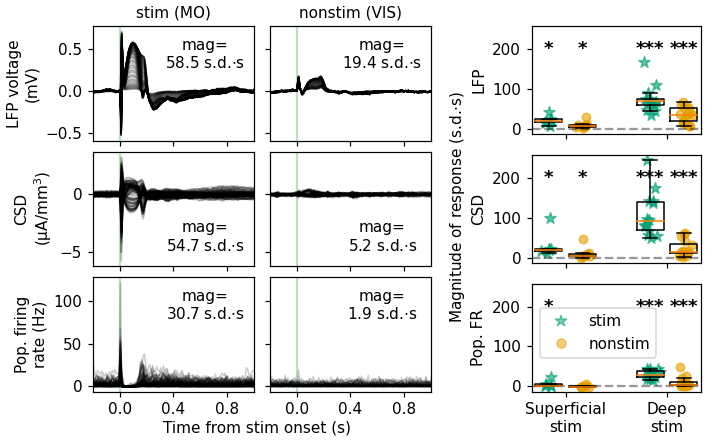

In [30]:
plot_stim = 'medium'
plot_state = 'awake'
compare = ['superficial', 'deep']
ctx_stim = {'stim': [True, CBbgreen, '*', 60], 'nonstim': [False, CBorange, 'o', 30]}
# ctx_stim = {'stim': [True], 'nonstim': [False]}
compdata = ['LFP', 'CSD', 'POPFR']
plot_win = [-0.2, 1.0]
plot_regs = example_traces['LFP'][plot_stim][plot_state].keys()
example_df = all_subs_auc_df[
    (all_subs_auc_df['group'] == list(example_mouse.keys())[0]) &
    (all_subs_auc_df['mouse'] == example_mouse[list(example_mouse.keys())[0]]) &
    (all_subs_auc_df['stim_level'] == plot_stim) & (all_subs_auc_df['state'] == plot_state)
]

## Plot params ##
tracetext = (0.6, 0.9)
locs1 = np.arange(len(compare) * (len(ctx_stim) + 1)).reshape((len(compare), (len(ctx_stim) + 1)))
#####

fig = plt.figure(figsize=(6.5, 4))
gs = fig.add_gridspec(ncols=2, nrows=1, left=0.13, right=0.98, top=0.94, bottom=0.11, width_ratios=[2,1], wspace=0.4)
traceaxs = gs[0].subgridspec(ncols=2, nrows=3, hspace=0.1, wspace=0.1).subplots(sharex=True, sharey='row')
metaxs = gs[1].subgridspec(ncols=1, nrows=3, hspace=0.2).subplots(sharex=True, sharey=True)

for ii, regi in enumerate(['MO', 'VIS']):
    ## Plot LFP ##
    LFPtime = example_traces['LFP'][plot_stim][plot_state][regi][0]
    LFPtraces = example_traces['LFP'][plot_stim][plot_state][regi][1] * 1E-3
    traceaxs[0,ii].axvline(0, color='g', alpha=0.25)
    traceaxs[0,ii].plot(LFPtime, LFPtraces, color='k', linewidth=1, alpha=0.2)
    traceaxs[0,ii].set_title('{} ({})'.format(list(ctx_stim.keys())[ii], regi))
    traceaxs[0,ii].set_xlim(plot_win)
    traceaxs[0,ii].set_xticks(np.arange(0, plot_win[1]+0.1, 0.4))
    LFPmag = example_df['LFPmagZ'][example_df['region'] == regi].values[0]
    traceaxs[0,ii].annotate(
        'mag=\n{:.1f} s.d.$\cdot$s'.format(LFPmag), xy=(0.7, 0.9), xycoords='axes fraction', ha='center', va='top')
    
    ## Plot CSD ##
    CSDtime = example_traces['CSD'][plot_stim][plot_state][regi][0]
    CSDtraces = example_traces['CSD'][plot_stim][plot_state][regi][1]
    traceaxs[1,ii].axvline(0, color='g', alpha=0.25)
    traceaxs[1,ii].plot(CSDtime, CSDtraces, color='k', linewidth=1, alpha=0.2)
    CSDmag = example_df['CSDmagZ'][example_df['region'] == regi].values[0]
    traceaxs[1,ii].annotate(
        'mag=\n{:.1f} s.d.$\cdot$s'.format(CSDmag), xy=(0.7, 0.4), xycoords='axes fraction', ha='center', va='top')
    
    ## Plot units ##
    POPtime = example_traces['POPFR'][plot_stim][plot_state][regi][0]
    POPtraces = example_traces['POPFR'][plot_stim][plot_state][regi][1]
    traceaxs[2,ii].axvline(0, color='g', alpha=0.25)
    traceaxs[2,ii].plot(POPtime, POPtraces, color='k', linewidth=1, alpha=0.2)
    POPmag = example_df['POPFRmagZ'][example_df['region'] == regi].values[0]
    traceaxs[2,ii].annotate(
        'mag=\n{:.1f} s.d.$\cdot$s'.format(POPmag), xy=(0.7, 0.9), xycoords='axes fraction', ha='center', va='top')
    
traceaxs[0,0].set_ylabel('LFP voltage\n(mV)')
traceaxs[1,0].set_ylabel('CSD\n($\mathregular{\u03bcA/mm^3}$)')
traceaxs[2,0].set_ylabel('Pop. firing\nrate (Hz)')
fig.text(0.36, 0.01, 'Time from stim onset (s)', ha='center', va='bottom')

## Plot significant responses ##
onesamp_ttest_pvals = np.zeros((len(compare), len(ctx_stim), len(compdata)), dtype=float)
for di, depthi in enumerate(compare):
    for ri, (stimlabel, stiminfo) in enumerate(ctx_stim.items()):
        df_mean = all_subs_auc_df[
            (all_subs_auc_df['stim_depth'] == depthi) & (all_subs_auc_df['state'] == plot_state) &
            (all_subs_auc_df['stim_level'] == plot_stim) & (all_subs_auc_df['stim_cortex'] == stiminfo[0])
        ].groupby(['subject']).mean()
        for rowi, datai in enumerate(compdata):
            if (di == 0) and (ri == 0):
                metaxs[rowi].axhline(0, color='k', linestyle='dashed', alpha=0.4)
            sub_zmags = df_mean[datai+'magZ'].values
            xs = np.random.normal(locs1[di,ri], 0.1, len(sub_zmags))
            metaxs[rowi].boxplot(sub_zmags, positions=[locs1[di,ri]], widths=[0.8], showfliers=False)
            metaxs[rowi].scatter(xs, sub_zmags, color=stiminfo[1], marker=stiminfo[2], s=stiminfo[3], alpha=0.6)
#             tstat, pval = stats.ttest_1samp(sub_zmags, popmean=0) # for normal distribution
            wilcoxon_res = stats.wilcoxon(sub_zmags) # non-parametric t-test
            onesamp_ttest_pvals[di,ri,rowi] = wilcoxon_res.pvalue

metaxs[0].set_xticks(np.mean(locs1[:,:-1], axis=1))
metaxs[0].set_xticklabels(['Superficial\nstim', 'Deep\nstim'])
metaxs[0].set_ylabel('LFP')
metaxs[1].set_ylabel('CSD')
metaxs[2].set_ylabel('Pop. FR')

## Correct for multiple comparisons ##
sig_TF, corr_pvals = pg.multicomp(onesamp_ttest_pvals, alpha=sigalpha, method='fdr_bh')
for di, depthi in enumerate(compare):
    for ri, (stimlabel, stiminfo) in enumerate(ctx_stim.items()):
        for rowi, datai in enumerate(compdata):
            if corr_pvals[di,ri,rowi] < sigalpha:
                metaxs[rowi].annotate(
                    p_stars(corr_pvals[di,ri,rowi]), xy=(locs1[di,ri], 200),
                    fontsize=12, fontweight='bold', ha='center', va='center'
                )

## Axes labels ##
fig.text(0.64, 0.53, 'Magnitude of response (s.d.$\cdot$s)', ha='center', va='center', rotation='vertical')

## Add legend ##
zleg = [
    Line2D([0], [0], linestyle='none', color=CBbgreen, marker='*', markersize=8, alpha=0.5, label='stim'),
    Line2D([0], [0], linestyle='none', color=CBorange, marker='o', alpha=0.5, label='nonstim')
]
metaxs[2].legend(handles=zleg, bbox_to_anchor=(0, 0.85), loc='upper left')

## Save ##
figname = 'Fig3_LFP-CSD-POP_magZ_{}_{}.png'.format(plot_state, date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

## Save as .pdf for Illustrator ##
# fig.savefig(os.path.join(plotsdir, 'AI_pdfs', figname.replace('.png', '.pdf')), transparent=True, dpi=300)

In [46]:
for di, depthi in enumerate(compare):
    for ri, (stimlabel, stiminfo) in enumerate(ctx_stim.items()):
        for rowi, datai in enumerate(compdata):
            print('{} {} {} p = {:.4E}'.format(depthi, stimlabel, datai, onesamp_ttest_pvals[di,ri,rowi]))

superficial stim LFP p = 3.1250E-02
superficial stim CSD p = 3.1250E-02
superficial stim POPFR p = 3.1250E-02
superficial nonstim LFP p = 7.8125E-03
superficial nonstim CSD p = 7.8125E-03
superficial nonstim POPFR p = 7.4219E-01
deep stim LFP p = 1.2207E-04
deep stim CSD p = 1.2207E-04
deep stim POPFR p = 1.2207E-04
deep nonstim LFP p = 3.0518E-05
deep nonstim CSD p = 3.0518E-05
deep nonstim POPFR p = 3.0518E-05


#### Print mean +/- SEM

In [32]:
for di, depthi in enumerate(compare):
    print(depthi)
    for ri, (stimlabel, stiminfo) in enumerate(ctx_stim.items()):
        print(' {}'.format(stimlabel))
        df_mean = all_subs_auc_df[
            (all_subs_auc_df['stim_depth'] == depthi) & (all_subs_auc_df['state'] == plot_state) &
            (all_subs_auc_df['stim_level'] == plot_stim) & (all_subs_auc_df['stim_cortex'] == stiminfo[0])
        ].groupby(['subject']).mean()
        for rowi, datai in enumerate(compdata):
            sub_zmags = df_mean[datai+'magZ'].values
            ## Test normality ##
            swstat, swp = stats.shapiro(sub_zmags)
            if swp < sigalpha:
                normtag = 'normal'
            else:
                normtag = 'not normal'
            print('  {}: {:d}/{:d}, median: {:.1f} [{:.1f}, {:.1f} IQR] ({}); p={:.1e}'.format(
                datai, np.sum(np.abs(sub_zmags) > 3), len(sub_zmags), np.median(sub_zmags),
                np.percentile(sub_zmags, 25), np.percentile(sub_zmags, 75), normtag, corr_pvals[di,ri,rowi]
            ))
        print('')

superficial
 stim
  LFP: 6/6, median: 19.5 [15.9, 23.3 IQR] (not normal); p=3.4e-02
  CSD: 6/6, median: 19.8 [16.8, 22.4 IQR] (normal); p=3.4e-02
  POPFR: 2/6, median: 1.9 [0.6, 5.7 IQR] (normal); p=3.4e-02

 nonstim
  LFP: 7/8, median: 7.3 [5.1, 9.9 IQR] (normal); p=1.2e-02
  CSD: 4/8, median: 3.9 [2.7, 10.0 IQR] (normal); p=1.2e-02
  POPFR: 1/8, median: -0.2 [-0.4, 0.3 IQR] (normal); p=7.4e-01

deep
 stim
  LFP: 14/14, median: 68.0 [59.1, 75.3 IQR] (normal); p=2.4e-04
  CSD: 14/14, median: 92.1 [68.9, 139.7 IQR] (not normal); p=2.4e-04
  POPFR: 14/14, median: 28.6 [23.0, 38.1 IQR] (not normal); p=2.4e-04

 nonstim
  LFP: 16/16, median: 34.8 [18.2, 52.7 IQR] (not normal); p=1.2e-04
  CSD: 15/16, median: 14.6 [11.8, 33.3 IQR] (normal); p=1.2e-04
  POPFR: 11/16, median: 4.5 [2.7, 9.9 IQR] (normal); p=1.2e-04



### Plot magnitudes on a log scale?? Doesn't quite work because there are slightly negative values.

<IPython.core.display.Javascript object>


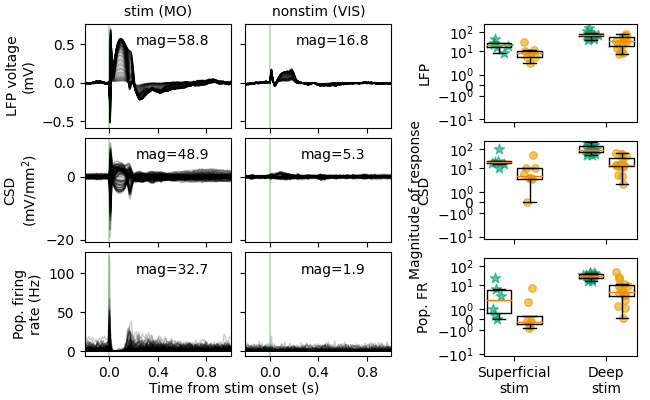

In [80]:
## log y-axis?? ##
plot_stim = 'medium'
plot_state = 'awake'
compare = ['superficial', 'deep']
ctx_stim = {'stim': [True, CBbgreen, '*', 60], 'nonstim': [False, CBorange, 'o', 30]}
# ctx_stim = {'stim': [True], 'nonstim': [False]}
compdata = ['LFP', 'CSD', 'POPFR']
plot_win = [-0.2, 1.0]
plot_regs = example_traces['LFP'][plot_stim][plot_state].keys()
example_df = all_subs_auc_df[
    (all_subs_auc_df['group'] == list(example_mouse.keys())[0]) &
    (all_subs_auc_df['mouse'] == example_mouse[list(example_mouse.keys())[0]]) &
    (all_subs_auc_df['stim_level'] == plot_stim) & (all_subs_auc_df['state'] == plot_state)
]

## Plot params ##
tracetext = (0.6, 0.9)
locs1 = np.arange(len(compare) * (len(ctx_stim) + 1)).reshape((len(compare), (len(ctx_stim) + 1)))
#####

fig = plt.figure(figsize=(6.5, 4))
gs = fig.add_gridspec(ncols=2, nrows=1, left=0.13, right=0.98, top=0.94, bottom=0.11, width_ratios=[2,1], wspace=0.4)
traceaxs = gs[0].subgridspec(ncols=2, nrows=3, hspace=0.1, wspace=0.1).subplots(sharex=True, sharey='row')
metaxs = gs[1].subgridspec(ncols=1, nrows=3, hspace=0.2).subplots(sharex=True, sharey=True) #, sharey=True

for ii, regi in enumerate(['MO', 'VIS']):
    ## Plot LFP ##
    LFPtime = example_traces['LFP'][plot_stim][plot_state][regi][0]
    LFPtraces = example_traces['LFP'][plot_stim][plot_state][regi][1] * 1E-3
    traceaxs[0,ii].axvline(0, color='g', alpha=0.25)
    traceaxs[0,ii].plot(LFPtime, LFPtraces, color='k', linewidth=1, alpha=0.2)
    traceaxs[0,ii].set_title('{} ({})'.format(list(ctx_stim.keys())[ii], regi))
    traceaxs[0,ii].set_xlim(plot_win)
    traceaxs[0,ii].set_xticks(np.arange(0, plot_win[1]+0.1, 0.4))
#     LFPpval = example_df['LFP_pcorr'][example_df['region'] == regi].values[0]
    LFPmag = example_df['LFPmagZ'][example_df['region'] == regi].values[0]
    traceaxs[0,ii].annotate('mag={:.1f}'.format(LFPmag), xy=tracetext, xycoords='axes fraction', ha='center', va='top')
#     traceaxs[0,ii].annotate(
#         'mag={:.1f}\n({})'.format(LFPmag, p_stars(LFPpval)), xy=tracetext, xycoords='axes fraction', ha='center', va='top'
#     ) # with p-value
    
    ## Plot CSD ##
    CSDtime = example_traces['CSD'][plot_stim][plot_state][regi][0]
    CSDtraces = example_traces['CSD'][plot_stim][plot_state][regi][1]
    traceaxs[1,ii].axvline(0, color='g', alpha=0.25)
    traceaxs[1,ii].plot(CSDtime, CSDtraces, color='k', linewidth=1, alpha=0.2)
#     CSDpval = example_df['CSD_pcorr'][example_df['region'] == regi].values[0]
    CSDmag = example_df['CSDmagZ'][example_df['region'] == regi].values[0]
    traceaxs[1,ii].annotate('mag={:.1f}'.format(CSDmag), xy=tracetext, xycoords='axes fraction', ha='center', va='top')
    
    ## Plot units ##
    POPtime = example_traces['POPFR'][plot_stim][plot_state][regi][0]
    POPtraces = example_traces['POPFR'][plot_stim][plot_state][regi][1]
    traceaxs[2,ii].axvline(0, color='g', alpha=0.25)
    traceaxs[2,ii].plot(POPtime, POPtraces, color='k', linewidth=1, alpha=0.2)
#     POPpval = example_df['POPFR_pcorr'][example_df['region'] == regi].values[0]
    POPmag = example_df['POPFRmagZ'][example_df['region'] == regi].values[0]
    traceaxs[2,ii].annotate('mag={:.1f}'.format(POPmag), xy=tracetext, xycoords='axes fraction', ha='center', va='top')
    
#     traceaxs[2,ii].set_xlabel('Time from stim onset (s)')
traceaxs[0,0].set_ylabel('LFP voltage\n(mV)')
traceaxs[1,0].set_ylabel('CSD\n($\mathregular{mV/mm^2}$)')
traceaxs[2,0].set_ylabel('Pop. firing\nrate (Hz)')
fig.text(0.36, 0.01, 'Time from stim onset (s)', ha='center', va='bottom')

## Plot significant responses ##
onesamp_ttest_pvals = np.zeros((len(compare), len(ctx_stim), len(compdata)), dtype=float)
for di, depthi in enumerate(compare):
    for ri, (stimlabel, stiminfo) in enumerate(ctx_stim.items()):
        df_mean = all_subs_auc_df[
            (all_subs_auc_df['stim_depth'] == depthi) & (all_subs_auc_df['state'] == plot_state) &
            (all_subs_auc_df['stim_level'] == plot_stim) & (all_subs_auc_df['stim_cortex'] == stiminfo[0])
        ].groupby(['subject']).mean()
        for rowi, datai in enumerate(compdata):
#             if (di == 0) and (ri == 0):
#                 metaxs[rowi].axhline(0, color='k', linestyle='dashed', alpha=0.4)
            sub_zmags = df_mean[datai+'magZ'].values
            xs = np.random.normal(locs1[di,ri], 0.1, len(sub_zmags))
            metaxs[rowi].boxplot(sub_zmags, positions=[locs1[di,ri]], widths=[0.8], showfliers=False)
            metaxs[rowi].scatter(xs, sub_zmags, color=stiminfo[1], marker=stiminfo[2], s=stiminfo[3], alpha=0.6)
#             tstat, pval = stats.ttest_1samp(sub_zmags, popmean=0) # for normal distribution
            wilcoxon_res = stats.wilcoxon(sub_zmags) # non-parametric t-test
            onesamp_ttest_pvals[di,ri,rowi] = wilcoxon_res.pvalue

metaxs[0].set_xticks(np.mean(locs1[:,:-1], axis=1))
metaxs[0].set_xticklabels(['Superficial\nstim', 'Deep\nstim'])
metaxs[0].set_ylabel('LFP')
metaxs[0].set_yscale('symlog')
metaxs[1].set_ylabel('CSD')
metaxs[2].set_ylabel('Pop. FR')

## Correct for multiple comparisons ##
# sig_TF, corr_pvals = pg.multicomp(onesamp_ttest_pvals, alpha=sigalpha, method='fdr_bh')
# for di, depthi in enumerate(compare):
#     for ri, (stimlabel, stiminfo) in enumerate(ctx_stim.items()):
#         for rowi, datai in enumerate(compdata):
#             if corr_pvals[di,ri,rowi] < sigalpha:
#                 metaxs[rowi].annotate(
#                     p_stars(corr_pvals[di,ri,rowi]), xy=(locs1[di,ri], 200),
#                     fontsize=12, fontweight='bold', ha='center', va='center'
#                 )

## Axes labels ##
fig.text(0.64, 0.5, 'Magnitude of response', ha='center', va='center', rotation='vertical')

## Add legend ##
zleg = [
    Line2D([0], [0], linestyle='none', color=CBbgreen, marker='*', markersize=8, alpha=0.5, label='stim'),
    Line2D([0], [0], linestyle='none', color=CBorange, marker='o', alpha=0.5, label='nonstim')
]
# metaxs[2].legend(handles=zleg, bbox_to_anchor=(0, 0.85), loc='upper left')

## Save ##
figname = 'Fig3_LFP-CSD-POP_magZ_{}_{}_logscale.png'.format(plot_state, date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

#### Plot the LFP-units comparison only

<IPython.core.display.Javascript object>


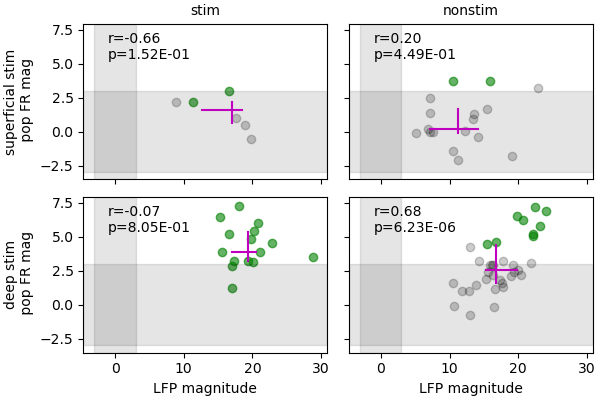

In [50]:
plot_stim = 'medium'
plot_state = 'resting'
compare = ['superficial', 'deep']
ctx_stim = {'stim': [True, 'g', '*', 100], 'nonstim': [False, 'k', 'o', 50]}
locs1 = np.arange(len(ctx_stim) * (len(comp) + 1)).reshape((len(ctx_stim), (len(comp) + 1)))
plot_regs = example_traces['LFP'][plot_stim][plot_state].keys()
example_df = all_subs_auc_df[
    (all_subs_auc_df['group'] == list(example_mouse.keys())[0]) &
    (all_subs_auc_df['mouse'] == example_mouse[list(example_mouse.keys())[0]]) &
    (all_subs_auc_df['stim_level'] == plot_stim) & (all_subs_auc_df['state'] == plot_state)
]

fig, axs = plt.subplots(
    nrows=len(compare), ncols=len(ctx_stim), figsize=(6, 4), sharex=True, sharey=True, constrained_layout=True)

for rowi, depthi in enumerate(compare):
    for coli, (stimlabel, stiminfo) in enumerate(ctx_stim.items()):
#         axs[rowi, coli].axvline(1, color='k', linewidth=1, linestyle='dashed', alpha=0.5)
#         axs[rowi, coli].axhline(1, color='k', linewidth=1, linestyle='dashed', alpha=0.5)
        axs[rowi, coli].axvspan(-3, 3, color='k', alpha=0.1)
        axs[rowi, coli].axhspan(-3, 3, color='k', alpha=0.1)
        
        dfa = all_subs_auc_df[
            (all_subs_auc_df['stim_depth'] == depthi) & (all_subs_auc_df['state'] == plot_state) &
            (all_subs_auc_df['stim_level'] == plot_stim) & (all_subs_auc_df['stim_cortex'] == stiminfo[0])
        ]
#         axs[rowi, coli].scatter(
#             dfa['LFPmag'].values, dfa['POPFRmag'].values, c='b', marker='o', alpha=0.4
#         )
        sigmask = (dfa['LFP_p'].values < sigalpha) * (dfa['POPFR_p'].values < sigalpha)
        axs[rowi, coli].scatter(
            dfa['LFPmag'].values[sigmask], dfa['POPFRmag'].values[sigmask], c='g', marker='o', alpha=0.6
        )
        axs[rowi, coli].scatter(
            dfa['LFPmag'].values[~sigmask], dfa['POPFRmag'].values[~sigmask], c='k', marker='o', alpha=0.2
        )
        
        ## Add median and quartile error bars ##
        axs[rowi, coli].plot(
            np.repeat(np.median(dfa['LFPmag'].values), 2), np.percentile(dfa['POPFRmag'].values, [25, 75]), color='m'
        )
        axs[rowi, coli].plot(
            np.percentile(dfa['LFPmag'].values, [25, 75]), np.repeat(np.median(dfa['POPFRmag'].values), 2), color='m'
        )
        
        
        ## Linear regression ##
        res = stats.linregress(dfa['LFPmag'].values, dfa['POPFRmag'].values)
        axs[rowi, coli].annotate(
            'r={:.2f}\np={:.3f}'.format(res.rvalue, res.pvalue), xy=(0.1, 0.85), xycoords='axes fraction',
            ha='left', va='center'
        )
#         if res.pvalue < sigalpha:
#             axs[rowi, coli]
        

        if rowi == 1:
            axs[rowi, coli].set_xlabel('LFP magnitude')
        else:
            axs[rowi, coli].set_title(stimlabel)
        
        if coli == 0:
            axs[rowi, coli].set_ylabel('{} stim\n pop FR mag'.format(depthi))

<IPython.core.display.Javascript object>


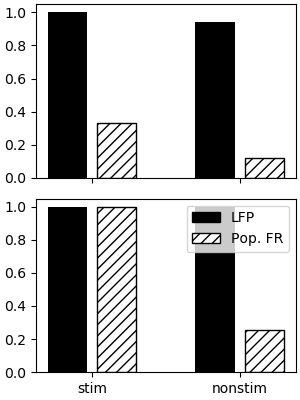

In [99]:
plot_stim = 'medium'
plot_state = 'resting'
compare = ['superficial', 'deep']
ctx_stim = {'stim': [True, 'g', '*', 100], 'nonstim': [False, 'k', 'o', 50]}
locs1 = np.arange(len(ctx_stim) * (len(comp) + 1)).reshape((len(ctx_stim), (len(comp) + 1)))
plot_regs = example_traces['LFP'][plot_stim][plot_state].keys()
example_df = all_subs_auc_df[
    (all_subs_auc_df['group'] == list(example_mouse.keys())[0]) &
    (all_subs_auc_df['mouse'] == example_mouse[list(example_mouse.keys())[0]]) &
    (all_subs_auc_df['stim_level'] == plot_stim) & (all_subs_auc_df['state'] == plot_state)
]

fig, axs = plt.subplots(
    nrows=len(compare), ncols=1, figsize=(3, 4), sharex=True, sharey=True, constrained_layout=True)

for rowi, depthi in enumerate(compare):
    for coli, (stimlabel, stiminfo) in enumerate(ctx_stim.items()):
        dfa = all_subs_auc_df[
            (all_subs_auc_df['stim_depth'] == depthi) & (all_subs_auc_df['state'] == plot_state) &
            (all_subs_auc_df['stim_level'] == plot_stim) & (all_subs_auc_df['stim_cortex'] == stiminfo[0])
        ]
        
        fractLFP = np.sum(dfa['LFP_p'].values < sigalpha) / len(dfa)
        fractPOP = np.sum(dfa['POPFR_p'].values < sigalpha) / len(dfa)
        
        axs[rowi].bar(locs1[coli, 0], fractLFP, color='k')
        axs[rowi].bar(locs1[coli, 1], fractPOP, color='w', edgecolor='k', hatch='///')
#         axs[rowi].set_ylabel('Fraction of significant responses')
        
axs[1].set_xticks(np.mean(locs1[:, :-1], axis=1))
axs[1].set_xticklabels(ctx_stim.keys())

## Make a legend ##
barleg = [
    Patch(facecolor='k', edgecolor='k', label='LFP'),
    Patch(facecolor='w', edgecolor='k', hatch='///', label='Pop. FR'),
]
axs[1].legend(handles=barleg)

Original analysis and figure